# Title ()

### 1. Setup & Installation

In [1]:
# !git clone https://github.com/NudelMaster/deep_learning_hw.git

# %pip install -r requirements.txt

### 2. Data Loading
Loads the data if binary files exist, otherwise automatically downloads and stores in /data directory

In [1]:
from torchvision import datasets

train_dataset = datasets.STL10(root='./data', split='train', download=True)
test_dataset = datasets.STL10(root='./data', split='test', download=True)

### 3. Data Visualization

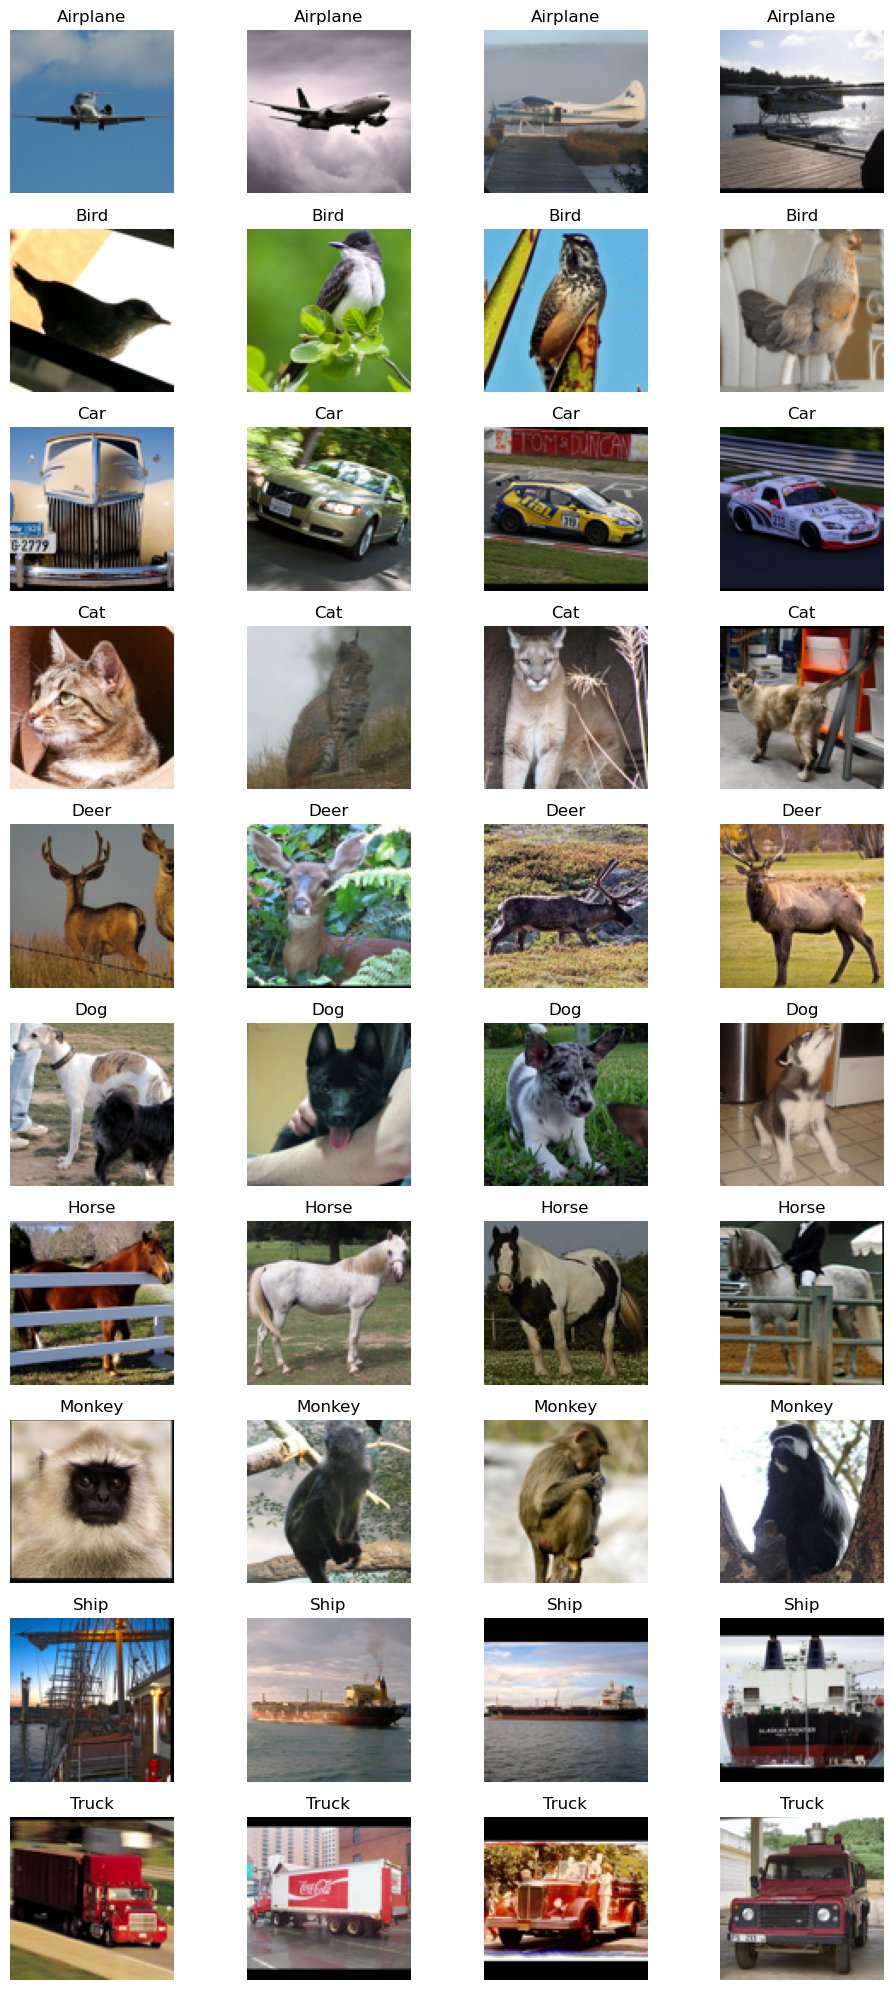

In [3]:
import numpy as np
import matplotlib.pyplot as plt
labels_map = {
    0 : "Airplane", 1 : "Bird", 2 : "Car", 3 : "Cat", 4 : "Deer",
    5 : "Dog", 6 : "Horse", 7 : "Monkey", 8 : "Ship", 9 : "Truck"
}
# plot 4 different examples from each class
# configure the plot
fig, axes = plt.subplots(nrows = 10, ncols = 4, figsize=(10,20))
# iterate over 10 classes
for i in range(10):
    # Filter data for this class
    class_i_examples = train_dataset.data[train_dataset.labels == i]

    # Pick 4 random indices
    idx = np.random.randint(0, class_i_examples.shape[0], 4)

    for j in range(4):
        img = class_i_examples[idx[j]]
        ax = axes[i, j]

        # Call the fixed function
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set_title(labels_map[i])

        # Remove axis ticks for cleanliness
        ax.axis("off")
plt.tight_layout()
plt.show()

### Visualize Augmentations

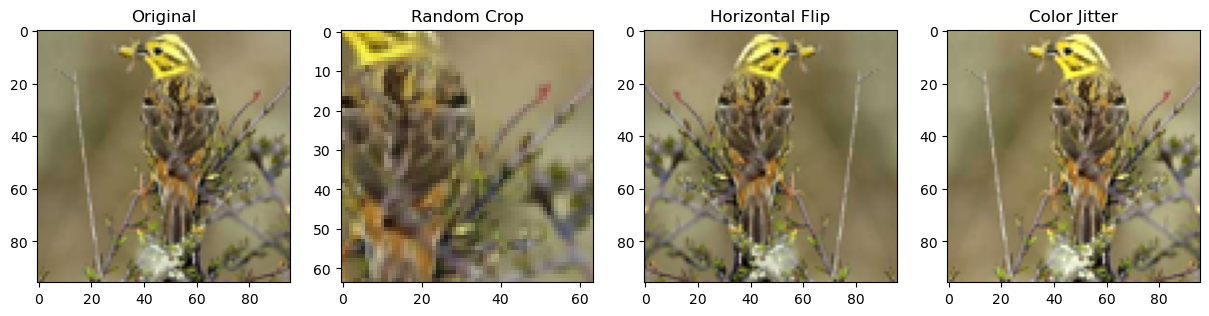

In [4]:
sample_img, _ = train_dataset[0] # Get a PIL image
import torchvision.transforms as transforms
# Define individual transforms to show them one by one
crop_tf = transforms.RandomResizedCrop(64)
flip_tf = transforms.RandomHorizontalFlip(p=1.0) # Force flip for the demo
color_tf = transforms.ColorJitter(brightness=0.5)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(sample_img); axes[0].set_title("Original")
axes[1].imshow(crop_tf(sample_img)); axes[1].set_title("Random Crop")
axes[2].imshow(flip_tf(sample_img)); axes[2].set_title("Horizontal Flip")
axes[3].imshow(color_tf(sample_img)); axes[3].set_title("Color Jitter")
plt.show()

### 4. Prepare Data and configurations

In [3]:
import torch
import models
import trainer
import utils
import data_setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_subset, val_subset, test_subset = data_setup.get_stl10_splits(train_dataset=train_dataset,
                                                                  test_dataset=test_dataset)


### Test accuracy helper

In [2]:

def test_model_performance(model, test_dataset, device, num_workers=0):
    model.eval()
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
    correct = 0
    total = 0

    print("Evaluating on Test Set...")
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Final Accuracy on the 8000 test images: {100 * correct / total:.2f} %')

### 5. Model implementations

In [7]:
model_names = ['logreg', 'nn', 'cnn', 'mobilenet']

- ### Logistic Regression

Starting grid search for 'logreg' with 36 candidates...


  0%|          | 0/36 [00:00<?, ?it/s]


Evaluating Config: {'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 64, 'weight_decay': 0, 'epochs': 15}
Model logreg built successfully.
Starting training for 15 epochs on cuda...
Epoch 1/15 | Train Loss: 28.5165 | Val Loss: 20.5581 | Val Acc: 24.20%
Epoch 10/15 | Train Loss: 26.2471 | Val Loss: 24.7506 | Val Acc: 17.00%
Epoch 15/15 | Train Loss: 25.2309 | Val Loss: 20.5932 | Val Acc: 23.80%
Best Val Acc: 24.70%

Evaluating Config: {'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 64, 'weight_decay': 0.001, 'epochs': 15}
Model logreg built successfully.
Starting training for 15 epochs on cuda...
Epoch 1/15 | Train Loss: 28.5132 | Val Loss: 21.9670 | Val Acc: 21.10%
Epoch 10/15 | Train Loss: 23.9146 | Val Loss: 23.2999 | Val Acc: 20.20%
Epoch 15/15 | Train Loss: 25.4553 | Val Loss: 19.9964 | Val Acc: 21.30%
Best Val Acc: 24.50%

Evaluating Config: {'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 64, 'weight_decay': 0.0001, 'epochs': 15}
Model logreg built 

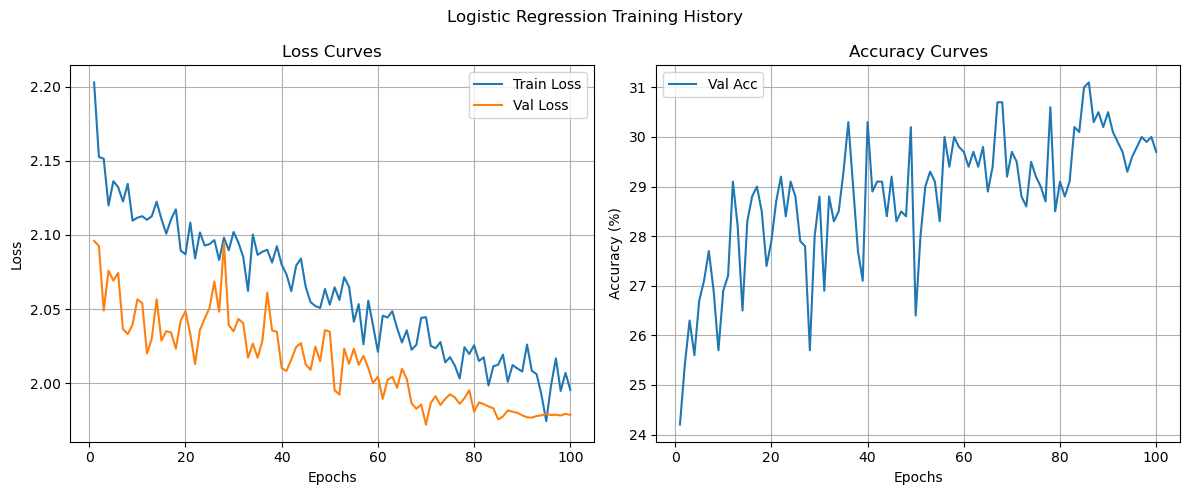

Evaluating on Test Set...
Final Accuracy on the 8000 test images: 30.62 %


In [ ]:
# Define hyperparameter grid for logistic regression model
# logreg_grid = {
#     'optimizer': ['adam', 'sgd'],
#     'learning_rate': [1e-2, 1e-3, 1e-4],
#     'batch_size': [64, 128],
#     'weight_decay': [0, 1e-3, 1e-4],
#     'epochs': [15]
# }


# Perform grid search for logistic regression
# results, best_logreg_config = \
#     trainer.run_grid_search(model_name='logreg', \
#     train_set = train_subset,\
#     val_set = val_subset, \
#     param_grid = logreg_grid, \
#     device=device, num_workers=8)



# Print top 10 results
# sorted_results = sorted(results, key=lambda x: x['best_val_acc'], reverse=True)
# print(f"Top 10 logreg Configurations:")
# for i, res in enumerate(sorted_results[:10]):
#     print(f"Rank {i+1}: Val Acc: {res['best_val_acc']:.2f}% | Config: {res['params']}")


# Best logistic regression configuration from grid search
best_logreg_config = {
    'optimizer': 'adam',
    'learning_rate': 1e-4,
    'batch_size': 64,
    'weight_decay': 0,
}

# Run best logistic regression model
best_logreg_config['epochs'] = 150
best_logreg_config['patience'] = 30
best_logreg_config['use_scheduler'] = True

logistic_regression = models.get_model(model_name='logreg', num_classes=10).to(device)


logreg_history = \
    trainer.train_model(model = logistic_regression, \
    train_set=train_subset, \
    val_set=val_subset, \
    config = best_logreg_config,\
    device=device, num_workers=8)


# Visualize training history
utils.plot_training_history(logreg_history, title="Logistic Regression Training History")


# Test logistic regression model
test_model_performance(logistic_regression, test_subset, device, num_workers=8)

- ### NN

Starting grid search for 'nn' with 72 candidates...


  0%|          | 0/72 [00:00<?, ?it/s]


Evaluating Config: {'hidden_dim': 512, 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32, 'weight_decay': 0, 'epochs': 15}
Model nn built successfully.
Starting training for 15 epochs on cuda...
Epoch 1/15 | Train Loss: 2.2154 | Val Loss: 1.9955 | Val Acc: 22.90%
Epoch 10/15 | Train Loss: 1.9604 | Val Loss: 1.8101 | Val Acc: 33.50%
Epoch 15/15 | Train Loss: 1.9416 | Val Loss: 1.7723 | Val Acc: 32.70%
Best Val Acc: 34.70%

Evaluating Config: {'hidden_dim': 512, 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32, 'weight_decay': 0.001, 'epochs': 15}
Model nn built successfully.
Starting training for 15 epochs on cuda...
Epoch 1/15 | Train Loss: 2.2142 | Val Loss: 2.0546 | Val Acc: 21.50%
Epoch 10/15 | Train Loss: 2.1397 | Val Loss: 2.0462 | Val Acc: 20.90%
Epoch 15/15 | Train Loss: 2.1455 | Val Loss: 2.0799 | Val Acc: 22.00%
Best Val Acc: 24.30%

Evaluating Config: {'hidden_dim': 512, 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32, 'weight_decay': 0.00

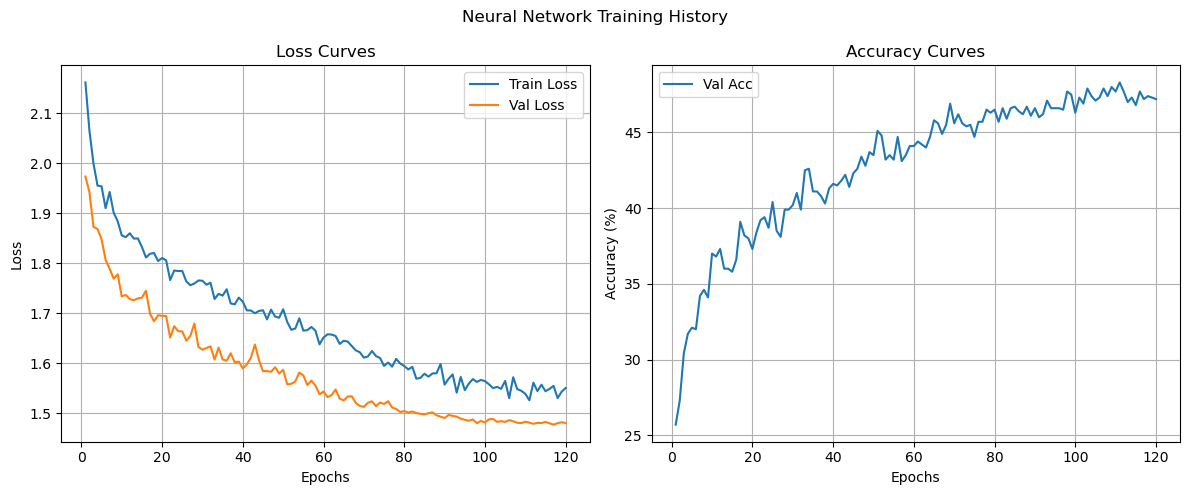

Evaluating on Test Set...
Final Accuracy on the 8000 test images: 46.02 %


In [ ]:
# Define hyperparameter grid for neural network model
# nn_grid = {
#     'hidden_dim': [512, 1024],
#     'optimizer': ['adam', 'sgd'],
#     'learning_rate': [1e-2, 1e-3, 1e-4],
#     'batch_size': [32, 64],
#     'weight_decay': [0, 1e-3, 1e-4],
#     'epochs': [15]
# }


# Perform grid search for neural network
# results, best_nn_config = \
#     trainer.run_grid_search('nn', \
#     train_set = train_subset, \
#     val_set = val_subset,\
#     param_grid = nn_grid, \
#     device=device, num_workers=8)


# Print top 10 results
# sorted_results = sorted(results, key=lambda x: x['best_val_acc'], reverse=True)
# print(f"Top 10 nn Configurations:")
# for i, res in enumerate(sorted_results[:10]):
#     print(f"Rank {i+1}: Val Acc: {res['best_val_acc']:.2f}% | Config: {res['params']}")

best_nn_config = {
    'hidden_dim': 1024,
    'optimizer': 'adam',
    'learning_rate': 1e-3,
    'batch_size': 64,
    'weight_decay': 0,
}

# Run best neural network model
best_nn_config['epochs'] = 150
best_nn_config['patience'] = 30
best_nn_config['use_scheduler'] = True


nn = models.get_model('nn', num_classes=10, hidden_dim=best_nn_config.get('hidden_dim', 512)).to(device)

nn_history = trainer.train_model(
    nn,
    train_set=train_subset,
    val_set=val_subset,
    config=best_nn_config,
    device=device,
    num_workers=8
)


# Visualize training history
utils.plot_training_history(nn_history, title="Neural Network Training History")
# Test neural network model
test_model_performance(nn, test_subset, device, num_workers=8)





- ### CNN

Starting grid search for 'cnn' with 48 candidates...


  0%|          | 0/48 [00:00<?, ?it/s]


Evaluating Config: {'base_width': 16, 'optimizer': 'adam', 'batch_size': 32, 'weight_decay': 0.001, 'learning_rate': 0.01, 'epochs': 15}
Model cnn built successfully.
Starting training for 15 epochs on cuda...
Epoch 1/15 | Train Loss: 2.6600 | Val Loss: 2.3040 | Val Acc: 9.70%
Epoch 10/15 | Train Loss: 2.3037 | Val Loss: 2.3048 | Val Acc: 10.10%
Epoch 15/15 | Train Loss: 2.3044 | Val Loss: 2.3067 | Val Acc: 10.00%
Best Val Acc: 11.70%

Evaluating Config: {'base_width': 16, 'optimizer': 'adam', 'batch_size': 32, 'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 15}
Model cnn built successfully.
Starting training for 15 epochs on cuda...
Epoch 1/15 | Train Loss: 2.2578 | Val Loss: 1.9486 | Val Acc: 19.70%
Epoch 10/15 | Train Loss: 1.7562 | Val Loss: 1.6231 | Val Acc: 35.10%
Epoch 15/15 | Train Loss: 1.6913 | Val Loss: 1.5721 | Val Acc: 34.60%
Best Val Acc: 38.50%

Evaluating Config: {'base_width': 16, 'optimizer': 'adam', 'batch_size': 32, 'weight_decay': 0.001, 'learning_rate': 

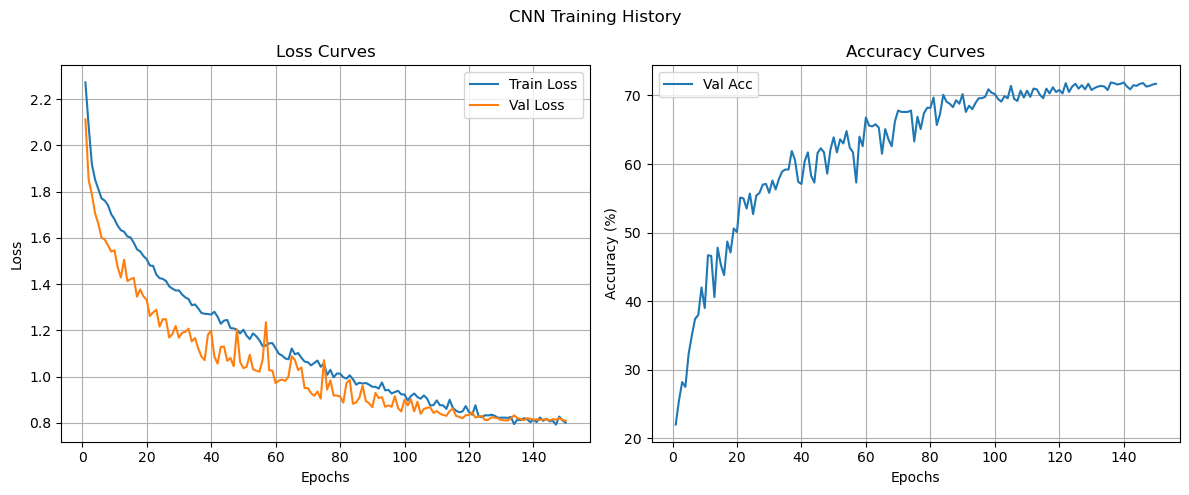

Evaluating on Test Set...
Final Accuracy on the 8000 test images: 73.86 %


In [ ]:
# Define hyperparameter grid for convolutional neural network model
# cnn_grid = {
#     'base_width': [16, 32],
#     'optimizer': ['adam', 'sgd'],
#     'batch_size': [32, 64],
#     'weight_decay': [1e-3, 1e-4],
#     'learning_rate': [1e-2, 1e-3, 5e-4],
#     'epochs': [15]
# }


# Perform grid search for convolutional neural network
# results, best_cnn_config = \
#     trainer.run_grid_search('cnn', \
#     train_set = train_subset, \
#     val_set = val_subset, \
#     param_grid = cnn_grid, device=device, \
#     num_workers=8)


# Print top 10 results
# sorted_results = sorted(results, key=lambda x: x['best_val_acc'], reverse=True)
# print(f"Top 10 CNN Configurations:")
# for i, res in enumerate(sorted_results[:10]):
#     print(f"Rank {i+1}: Val Acc: {res['best_val_acc']:.2f}% | Config: {res['params']}")

best_cnn_config = {
    'base_width': 32,
    'optimizer': 'sgd',
    'learning_rate': 1e-3,
    'batch_size': 32,
    'weight_decay': 1e-4,
}

# Run best convolutional neural network model
best_cnn_config['epochs'] = 150
best_cnn_config['patience'] = 30
best_cnn_config['use_scheduler'] = True

cnn = models.get_model('cnn', num_classes=10, **best_cnn_config).to(device)

cnn_history = \
    trainer.train_model(cnn, \
    train_set = train_subset, \
    val_set = val_subset, \
    config = best_cnn_config, \
    device=device, num_workers=8)


# Plot training history for the best CNN model
utils.plot_training_history(cnn_history, title="CNN Training History")



# Test model performance
test_model_performance(cnn, test_subset, device, num_workers=8)

 - ### MobileNet as Feature Extraction with Frozen weights

Starting grid search for 'mobilenet' with 48 candidates...


  0%|          | 0/48 [00:00<?, ?it/s]


Evaluating Config: {'freeze_backbone': True, 'weight_decay': 0.001, 'hidden_dim': 256, 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 15}
Model mobilenet built successfully.
Starting training for 15 epochs on cuda...
Epoch 1/15 | Train Loss: 1.6259 | Val Loss: 1.1232 | Val Acc: 61.10%
Epoch 10/15 | Train Loss: 1.4364 | Val Loss: 1.1519 | Val Acc: 61.10%
Epoch 15/15 | Train Loss: 1.4371 | Val Loss: 1.0597 | Val Acc: 64.40%
Best Val Acc: 67.80%

Evaluating Config: {'freeze_backbone': True, 'weight_decay': 0.001, 'hidden_dim': 256, 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15}
Model mobilenet built successfully.
Starting training for 15 epochs on cuda...
Epoch 1/15 | Train Loss: 1.5344 | Val Loss: 0.9535 | Val Acc: 68.50%
Epoch 10/15 | Train Loss: 1.2807 | Val Loss: 0.9488 | Val Acc: 67.30%
Epoch 15/15 | Train Loss: 1.2560 | Val Loss: 0.9605 | Val Acc: 71.40%
Best Val Acc: 71.40%

Evaluating Config: {'freeze_backbone': True, 'weight_

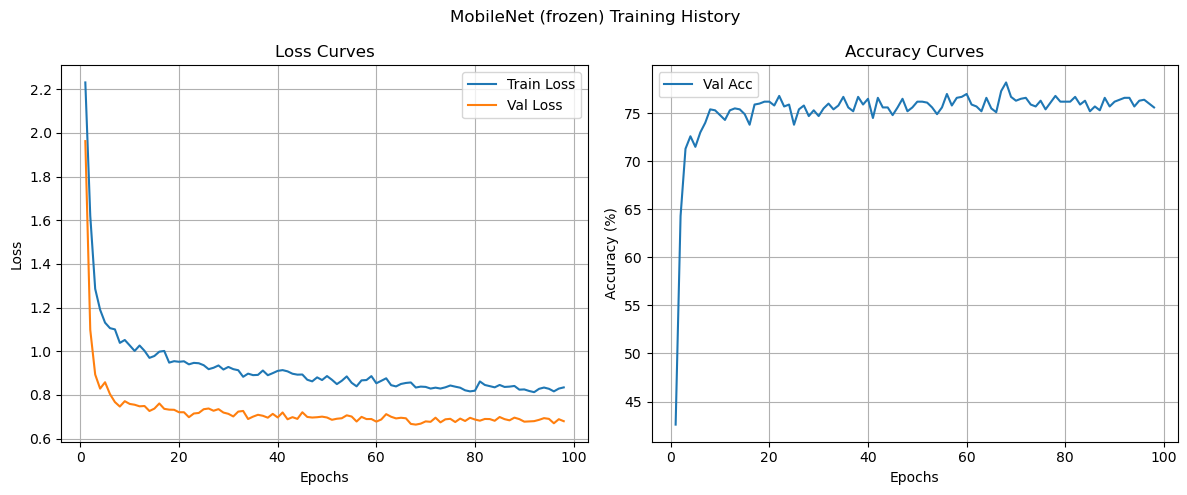

NameError: name 'test_model_performance' is not defined

In [ ]:
# Define hyperparameter grid for MobileNet model with frozen backbone
# mobilenet_frozen_grid = {
#     'freeze_backbone': [True],
#     'weight_decay': [1e-3, 1e-4],
#     'hidden_dim': [256, 512],
#     'optimizer': ['adam', 'sgd'],
#     'learning_rate': [1e-2, 1e-3, 1e-4],
#     'batch_size': [32,64],
#     'epochs': [15]
# }

# Perform grid search for MobileNet (frozen)
# results, best_mobile_net_frozen_config = trainer.run_grid_search('mobilenet', \
#     train_set = train_subset, \
#     val_set = val_subset, \
#     param_grid = mobilenet_frozen_grid,\
#     device=device, \
#     num_workers=8)


# Print top 10 results
# print("Top 10 MobileNet (frozen) Configurations:")
# sorted_results = sorted(results, key=lambda x: x['best_val_acc'], reverse=True)
# for i, res in enumerate(sorted_results[:10]):
#     print(f"Rank {i+1}: Val Acc: {res['best_val_acc']:.2f}% | Config: {res['params']}")

best_mobile_net_frozen_config = {'freeze_backbone': True, 
                                 'weight_decay': 0.001, 
                                 'hidden_dim': 256, 
                                 'optimizer': 'sgd', 
                                 'learning_rate': 0.01, 
                                 'batch_size': 64}


# Run best MobileNet (frozen) model

best_mobile_net_frozen_config['epochs'] = 150
best_mobile_net_frozen_config['patience'] = 30
best_mobile_net_frozen_config['use_scheduler'] = True


mobile_net_frozen = \
    models.get_model('mobilenet', num_classes=10, **best_mobile_net_frozen_config).to(device)


mobile_net_frozen_history = \
    trainer.train_model(mobile_net_frozen, \
    train_set = train_subset, \
    val_set = val_subset, \
    config = best_mobile_net_frozen_config, \
    device=device, num_workers=8)


# Plot training history for the best MobileNet (frozen) model
utils.plot_training_history(mobile_net_frozen_history, title="MobileNet (frozen) Training History")





In [5]:
# Test MobileNet (frozen) model
test_model_performance(mobile_net_frozen, test_subset, device, num_workers=8)

Evaluating on Test Set...
Final Accuracy on the 8000 test images: 76.80 %


- ### Mobile Net finetuned

Starting grid search for 'mobilenet' with 48 candidates...


  0%|          | 0/48 [00:00<?, ?it/s]


Evaluating Config: {'freeze_backbone': False, 'weight_decay': 0.001, 'hidden_dim': 256, 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 15}
Model mobilenet built successfully.
Starting training for 15 epochs on cuda...
Epoch 1/15 | Train Loss: 2.0979 | Val Loss: 2.8272 | Val Acc: 9.30%
Epoch 10/15 | Train Loss: 1.8437 | Val Loss: 2.0671 | Val Acc: 17.90%
Epoch 15/15 | Train Loss: 1.8492 | Val Loss: 1.7810 | Val Acc: 21.20%
Best Val Acc: 24.50%

Evaluating Config: {'freeze_backbone': False, 'weight_decay': 0.001, 'hidden_dim': 256, 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15}
Model mobilenet built successfully.
Starting training for 15 epochs on cuda...
Epoch 1/15 | Train Loss: 2.0905 | Val Loss: 2.1620 | Val Acc: 11.30%
Epoch 10/15 | Train Loss: 1.8336 | Val Loss: 1.9537 | Val Acc: 17.90%
Epoch 15/15 | Train Loss: 1.8302 | Val Loss: 2.2412 | Val Acc: 17.00%
Best Val Acc: 21.00%

Evaluating Config: {'freeze_backbone': False, 'weigh

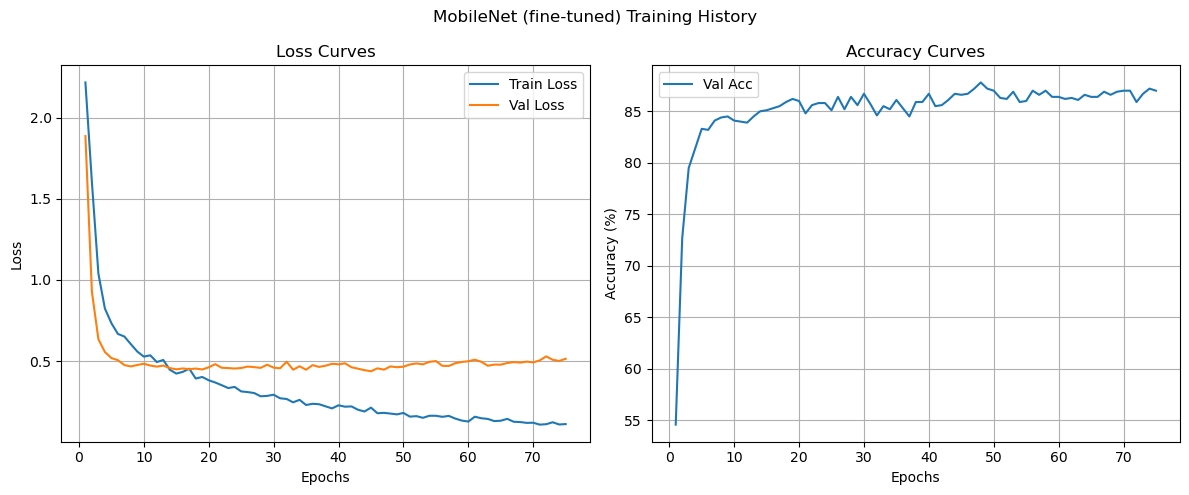

Evaluating on Test Set...
Final Accuracy on the 8000 test images: 87.81 %


In [ ]:
# Define hyperparameter grid for MobileNet model (fine-tuned)
# mobilenet_grid = {
#     'freeze_backbone': [False],
#     'weight_decay': [1e-3, 1e-4],
#     'hidden_dim': [256, 512],
#     'optimizer': ['adam', 'sgd'],
#     'learning_rate': [1e-2, 1e-3, 1e-4],
#     'batch_size': [32,64],
#     'epochs': [15]
# }


# Run grid search for MobileNet (fine-tuned)
# results, best_mobile_net_config = \
#     trainer.run_grid_search('mobilenet', \
#     train_set = train_subset, \
#     val_set = val_subset, \
#     param_grid = mobilenet_grid, \
#     device=device, \
#     num_workers=8)

# Print top 10 results
# print("Top 10 MobileNet (fine-tuned) Configurations:")
# sorted_results = sorted(results, key=lambda x: x['best_val_acc'], reverse=True)
# for i, res in enumerate(sorted_results[:10]):
#     print(f"Rank {i+1}: Val Acc: {res['best_val_acc']:.2f}% | Config: {res['params']}")

# Run best MobileNet (fine-tuned) model

best_mobile_net_config = {'freeze_backbone': False,
                        'weight_decay': 1e-3, 
                        'hidden_dim': 256, 
                        'optimizer': 'adam', 
                        'learning_rate': 1e-4, 
                        'batch_size': 64, 
                        'epochs': 15, 
                        'compute_train_acc': True}

best_mobile_net_config['epochs'] = 150
best_mobile_net_config['patience'] = 30
best_mobile_net_config['use_scheduler'] = True


mobile_net_fine_tuned = models.get_model('mobilenet', num_classes=10, **best_mobile_net_config).to(device)


mobile_net_fine_tuned_history = \
    trainer.train_model(mobile_net_fine_tuned, \
    train_set = train_subset, \
    val_set = val_subset, \
    config = best_mobile_net_config,\
    device=device, num_workers=8)

# Plot training history for the best MobileNet (fine-tuned) model
utils.plot_training_history(mobile_net_fine_tuned_history, title="MobileNet (fine-tuned) Training History")

# Test MobileNet (fine-tuned) model
test_model_performance(mobile_net_fine_tuned, test_subset, device, num_workers=8)